In [1]:
import numpy as np
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import losses
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
from pandas import DataFrame
import xlsxwriter

ct_sheet = pd.ExcelFile("All CTSA 2-1yr No Interpolated Samples.xlsx") 

Using TensorFlow backend.


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(585, 148)
(585, 148)
Tensor("input_1:0", shape=(None, 148), dtype=float32)
Epoch 1/150
585/585 [==============================] - 1s 2ms/step - loss: 0.1732
Epoch 2/150
585/585 [==============================] - 0s 190us/step - loss: 0.1061
Epoch 3/150
585/585 [==============================] - 0s 173us/step - loss: 0.0933
Epoch 4/150
585/585 [==============================] - 0s 168us/step - loss: 0.0902
Epoch 5/150
585/585 [==============================] - 0s 167us/step - loss: 0.0853
Epoch 6/150
585/585 [==============================] - 0s 173us/step - loss: 0.0834
Epoch 7/150
585/585 [==============================] - 0s 191us/step - loss: 0.0824
Epoch 8/150
585/585 [==============================] - 0s 192us/step - loss: 0.0811
Epoch 9/150
585/585 [==============================] - 0s 176us/step - loss: 0.0799
Epoch 10/150
585/585 [==============================] - 0s 190us/step - loss: 0.0799
Epoch 11/150
585/585 [==============================] - 0s 221us/step - loss: 0.0786


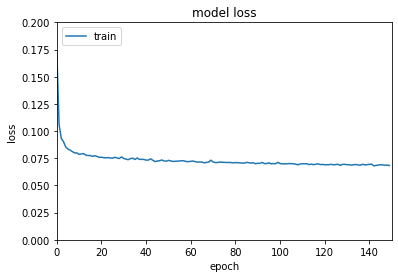

In [2]:
parsee = ct_sheet.sheet_names[0]
data = ct_sheet.parse(parsee)
data_features = data.loc[:, data.columns] 
data_features = data_features.drop(['ROI',11142,12142], axis=1)  

parsee2 = ct_sheet.sheet_names[1]
data2 = ct_sheet.parse(parsee2)
data_labels = data2.loc[:, data2.columns] 
data_labels = data_labels.drop(['ROI',11142,12142], axis=1)  
#Get rid of subject names to only have features now. #Need to remove ROIs. They don't convert to floats.
#Get rid of ctx_rh_Medial_wall and ctx_lh_Medial_wall, not needed for analysis.
scaler_filename = "IBIS_scaledCT1y.save"
scaler = joblib.load(scaler_filename)
scaled_data_1y = scaler.transform(data_features)

scaler_filename2 = "IBIS_scaledCT2y.save"
scaler2 = joblib.load(scaler_filename2)
scaled_data_2y = scaler.transform(data_labels)
print(scaled_data_1y.shape)
print(scaled_data_2y.shape)

#Size of encoded representation
#{'batch_size': 20, 'dropout': 0.2, 'encoded_layer_size': 25, 'epochs': 150, 'layer1_size': 100, 'layer2_size': 25}
input_size = 148
hidden_size = 100
hidden_size_2 = 25
encoding_dim = 25
dropout = 0.2

# Input Placeholder
input_data = Input(shape=(input_size,))
print(input_data)
# "encoded" is the encoded representation of the input
hidden_e_1 = Dense(hidden_size, activation='tanh')(input_data) 
hidden_e_2 = Dense(hidden_size_2, activation='tanh')(hidden_e_1)
dropout_layer = Dropout(dropout)(hidden_e_2)
encoded = Dense(encoding_dim, activation='tanh')(dropout_layer)
# "decoded" is the lossy reconstruction of the input
hidden_d_1 = Dense(hidden_size, activation='tanh')(encoded)
dropout_layer_d = Dropout(dropout)(hidden_d_1)
hidden_d_2 = Dense(hidden_size, activation='tanh')(dropout_layer_d)
decoded = Dense(input_size, activation='tanh')(hidden_d_2) 
# this model maps an input to its prediction
autoencoder = Model(input_data, decoded)
# configure our model to use mean_absolute_error loss function, and the Adam optimizer:
autoencoder.compile(optimizer='Adam', loss='mean_absolute_error')

ac = autoencoder.fit(scaled_data_1y, scaled_data_2y,
epochs=150,
batch_size=20,
shuffle=True)

#print(ac.history.keys())
# "Loss"
plt.plot(ac.history['loss'])
#plt.plot(ac.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
#plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, 150, 0.0, 0.2])
plt.show()

In [3]:
ct_sheet_1y = pd.ExcelFile("Data to be Interpolated.xlsx") 
parsee = ct_sheet_1y.sheet_names[1]
print(parsee)
data = ct_sheet_1y.parse(parsee)
data_features_ct1y = data.loc[:, data.columns] 
data_features_ct1y = data_features_ct1y.drop(['ROI',11142,12142], axis=1)
scaled_data_ct1y = scaler.transform(data_features_ct1y)
print(scaled_data_ct1y.shape)

predicted_2yr_ct = autoencoder.predict(scaled_data_ct1y)

1Y CT
(36, 148)


In [4]:
print(predicted_2yr_ct)

[[-0.2519557  -0.08653613  0.22962338 ... -0.16984178 -0.2718057
   0.13575247]
 [-0.30796313 -0.15148298  0.2504605  ... -0.20139779 -0.2831839
   0.167062  ]
 [-0.29810286 -0.14846778  0.1963547  ... -0.19581646 -0.32077962
   0.12987016]
 ...
 [-0.27366835 -0.13001922  0.2538602  ... -0.16014507 -0.23895419
   0.16543652]
 [-0.32362747 -0.15757506  0.21205251 ... -0.20184277 -0.32508138
   0.12340575]
 [-0.27033406 -0.0683869   0.24986526 ... -0.17246194 -0.25193137
   0.14662799]]


In [5]:
df = pd.DataFrame(predicted_2yr_ct)
df.to_excel("Interpolated CT 2y.xlsx", index=False)

In [6]:
df

,0,1,2,3,4,5,6,7,8,9,...,138,139,140,141,142,143,144,145,146,147
0,-0.251956,-0.086536,0.229623,0.060261,-0.231089,0.329678,0.181465,-0.134226,0.083773,0.029931,...,0.060601,0.225356,-0.107697,-0.011520,0.212043,0.244216,-0.341714,-0.169842,-0.271806,0.135752
1,-0.307963,-0.151483,0.250461,0.073782,-0.288914,0.307456,0.172618,-0.083658,0.171570,0.020927,...,0.062140,0.206907,-0.082339,-0.009215,0.230618,0.199203,-0.287597,-0.201398,-0.283184,0.167062
2,-0.298103,-0.148468,0.196355,0.038655,-0.277678,0.289809,0.138549,-0.164468,0.087299,-0.036124,...,0.010447,0.122495,-0.131964,-0.046544,0.200873,0.205313,-0.358060,-0.195816,-0.320780,0.129870
3,-0.275011,-0.083852,0.303753,0.079348,-0.243501,0.341732,0.235975,-0.033882,0.228387,0.115196,...,0.112395,0.277172,-0.053011,0.014025,0.251495,0.215785,-0.288268,-0.173977,-0.246824,0.165108
4,-0.305531,-0.193406,0.199527,0.005128,-0.274699,0.268989,0.128775,-0.185563,0.000003,-0.141069,...,-0.059635,0.033154,-0.175126,-0.074393,0.190984,0.183929,-0.389665,-0.209995,-0.387237,0.092031
5,-0.173216,-0.014909,0.313401,0.139171,-0.157237,0.393827,0.215986,-0.053404,0.107051,0.014809,...,0.106202,0.240106,-0.015997,0.040058,0.245805,0.288276,-0.260158,-0.133241,-0.223034,0.154821
6,-0.269016,-0.129994,0.165262,0.043989,-0.248203,0.311453,0.163676,-0.153959,0.120982,0.061642,...,0.034105,0.200373,-0.163354,-0.026494,0.202648,0.249027,-0.355928,-0.167552,-0.293540,0.121553
7,-0.252195,-0.082145,0.249939,0.075185,-0.225409,0.325181,0.174215,-0.116383,0.136041,0.082506,...,0.096328,0.243339,-0.081195,0.012819,0.230025,0.229197,-0.325938,-0.165929,-0.244115,0.152354
8,-0.272564,-0.131816,0.229689,0.040125,-0.245134,0.311529,0.166316,-0.133505,0.146742,0.091382,...,0.086509,0.176419,-0.111145,-0.003871,0.225488,0.220479,-0.351988,-0.164943,-0.255861,0.142492
9,-0.266866,-0.143331,0.206677,0.050360,-0.257803,0.316386,0.147470,-0.154189,0.114393,0.017203,...,0.045864,0.188268,-0.107712,-0.018082,0.215560,0.229852,-0.350972,-0.179884,-0.287171,0.136432
